In [3]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import os.path
import glob
#http://petermoran.org/robust-lane-tracking/

In [118]:
def read_points(obj_file='obj_points.p', img_file='img_points.p', show=False, rewrite=False):

    if os.path.isfile(obj_file):
        obj_points = pickle.load(open(obj_file, 'rb'))

    if os.path.isfile(img_file):
        img_points = pickle.load(open(img_file, 'rb'))

    if rewrite:
        obj_points = []
        img_points = []
        images = glob.glob('./camera_cal/calibration*.jpg')
        obj_p = np.zeros((6 * 9, 3), np.float32)
        obj_p[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

        for f_name in images:
            img = cv2.imread(f_name)
            # grayscale image
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
            if ret == True:
                img_points.append(corners)
                obj_points.append(obj_p)
                # Draw and display the corners
                if show:
                    cv2.drawChessboardCorners(img, (9, 6), corners, ret)
                    plt.imshow(img)
        pickle.dump(obj_points, open(obj_file, "wb"))
        pickle.dump(img_points, open(img_file, "wb"))

    return obj_points, img_points


def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


def perspective_tr(img, src, dst, img_size):
    t_m = cv2.getPerspectiveTransform(src, dst)
    tr_img = cv2.warpPerspective(img, t_m, img_size, flags=cv2.INTER_LINEAR)
    inv_m = cv2.getPerspectiveTransform(dst, src)
    return tr_img, t_m, inv_m

# TODO : https://github.com/js1972/CarND-Advanced-Lane-Lines/blob/master/Advanced%20Lane%20Line%20Finding%20Workbook.ipynb

def gradient(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary


def get_curvature(leftx, lefty, rightx, righty, ploty, image_size):
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = (
                     (1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad


def lane_lines(binary_warped, visualise=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    if visualise:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if visualise:
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                          (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                          (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if visualise:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return left_fit, right_fit, out_img
    else:
        return left_fit, right_fit
    
    

def lane_lines2(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                         left_fit[1] * nonzeroy + left_fit[
                                                                             2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
   
    return left_fit, right_fit

def fit_lanes(warped, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

def draw(warped, undist, Minv, left_fit, right_fit):
    #Draw lanes on scene   
    left_fitx, right_fitx, ploty = fit_lanes(warped, left_fit, right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    #TODO: add left_r, right_r, deviation

    return result

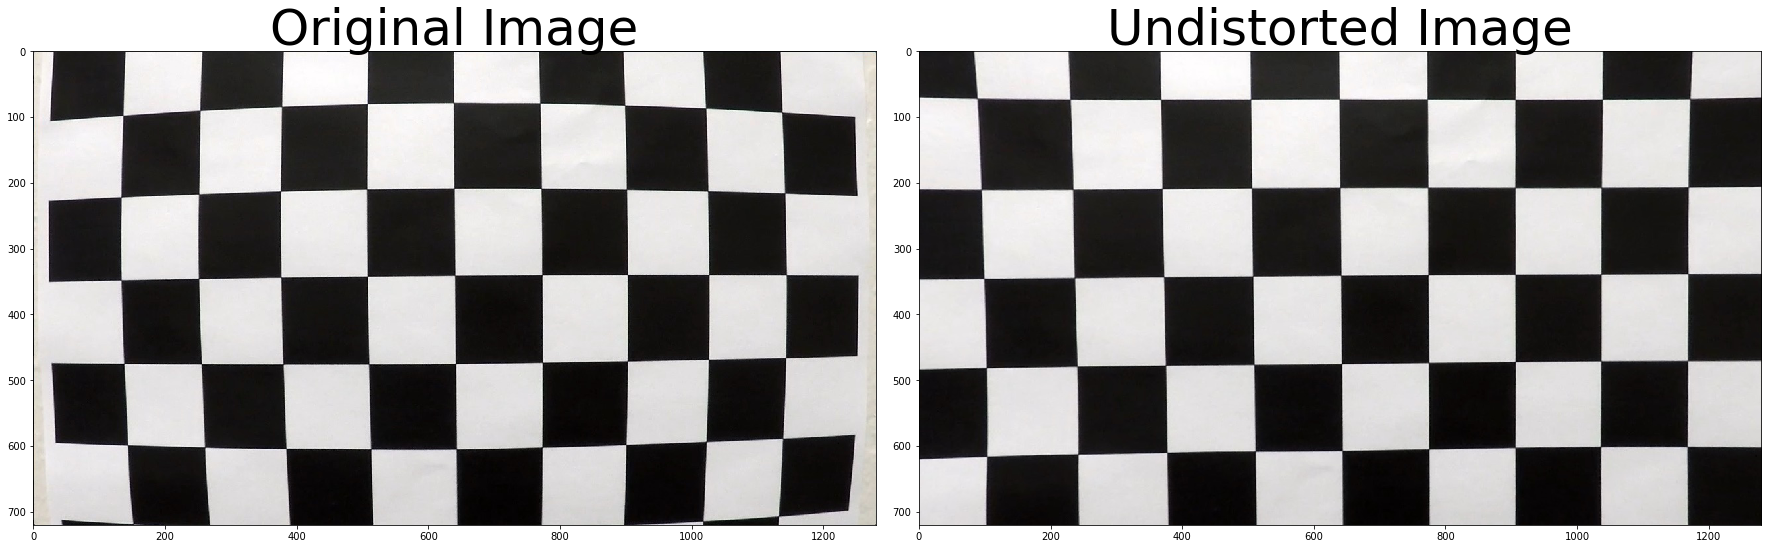

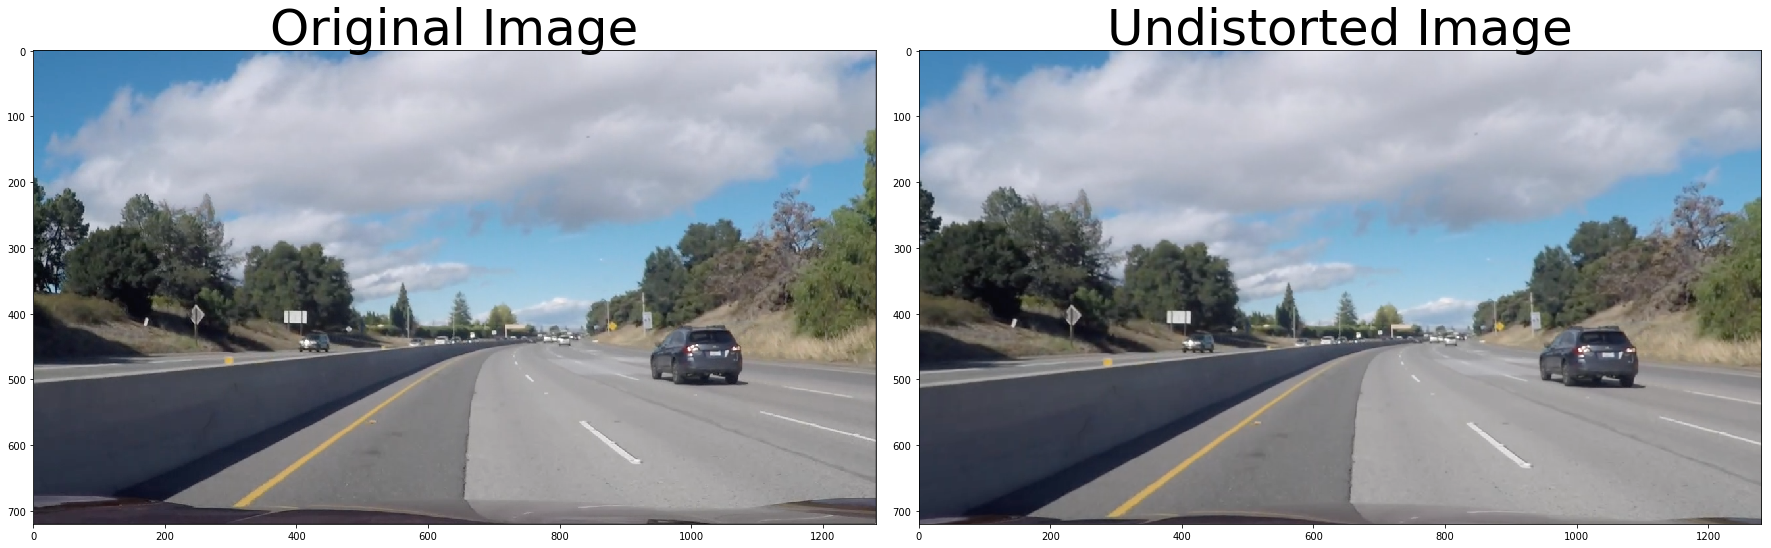

In [161]:
def show_und(img, undistorted):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

%matplotlib inline
obj_points, img_points = read_points(rewrite=False, show=False)
# Show train result
img = cv2.imread('./camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cal_undistort(img, obj_points, img_points)
show_und(img, undistorted)
# Show test result
img = cv2.imread('./test_images/challenge.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cal_undistort(img, obj_points, img_points)
show_und(img, undistorted)

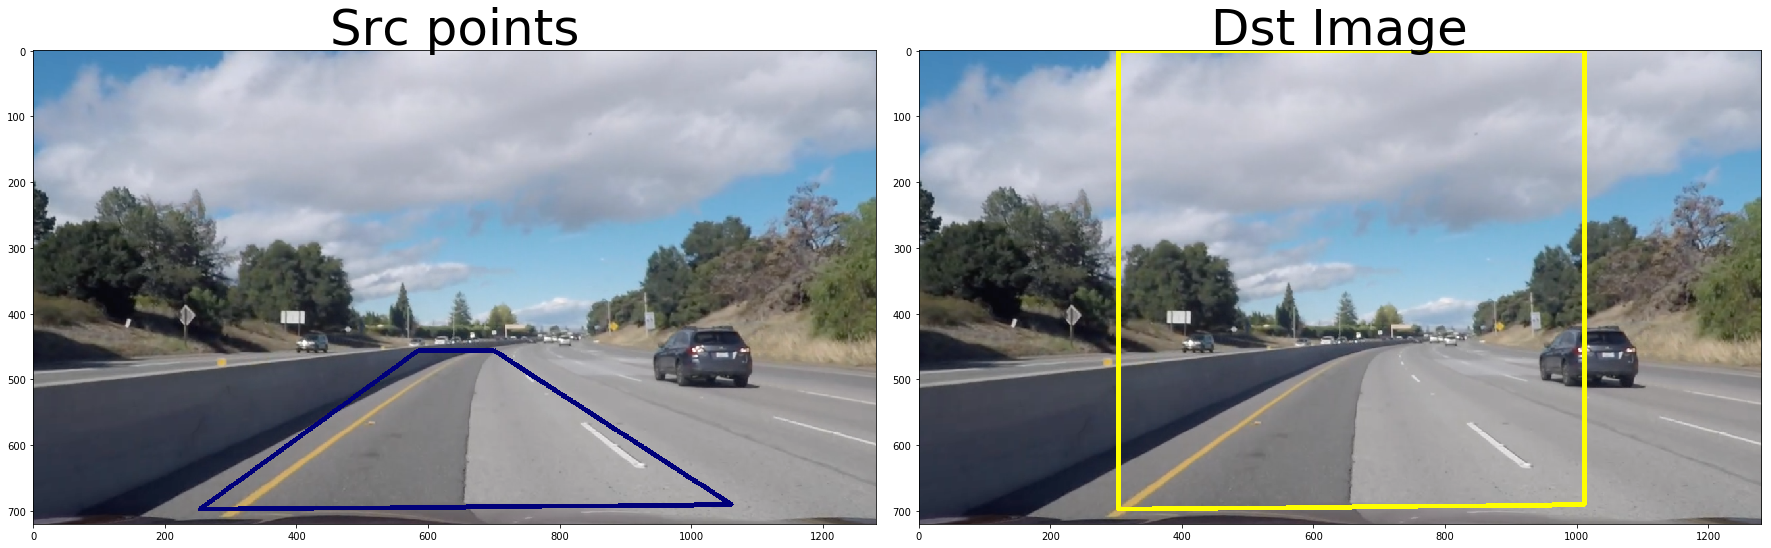

In [162]:
img = undistorted

w = img.shape[1]
h = img.shape[0]

src_img = img.copy()
dst_img = img.copy()

corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
cv2.polylines(src_img, np.int32([src]), True, (0, 0, 122), thickness=5)
cv2.polylines(dst_img, np.int32([dst]), True, (255, 255, 0), thickness=5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(src_img)
ax1.set_title('Src points', fontsize=50)
ax2.imshow(dst_img)
ax2.set_title('Dst Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

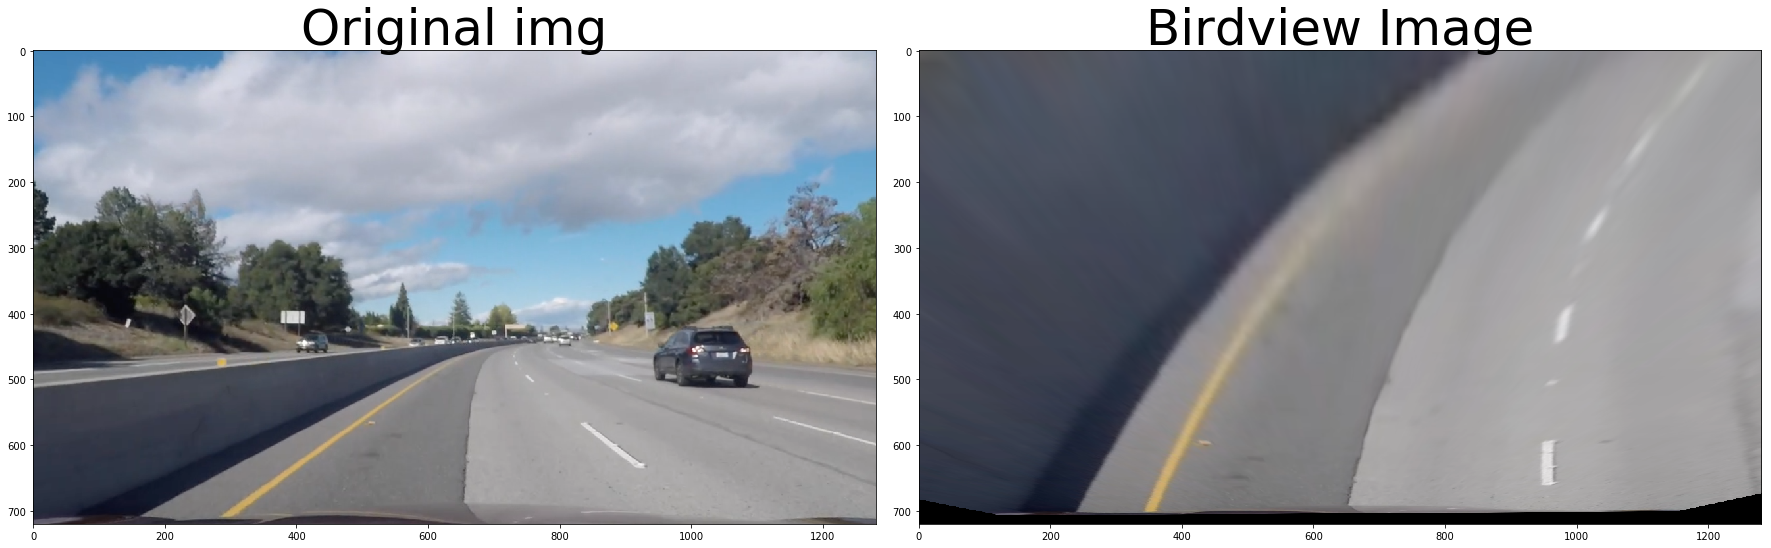

In [163]:
tr_img, t_m, inv_m = perspective_tr(img, src, dst, (img.shape[1], img.shape[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original img', fontsize=50)
ax2.imshow(tr_img)
ax2.set_title('Birdview Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

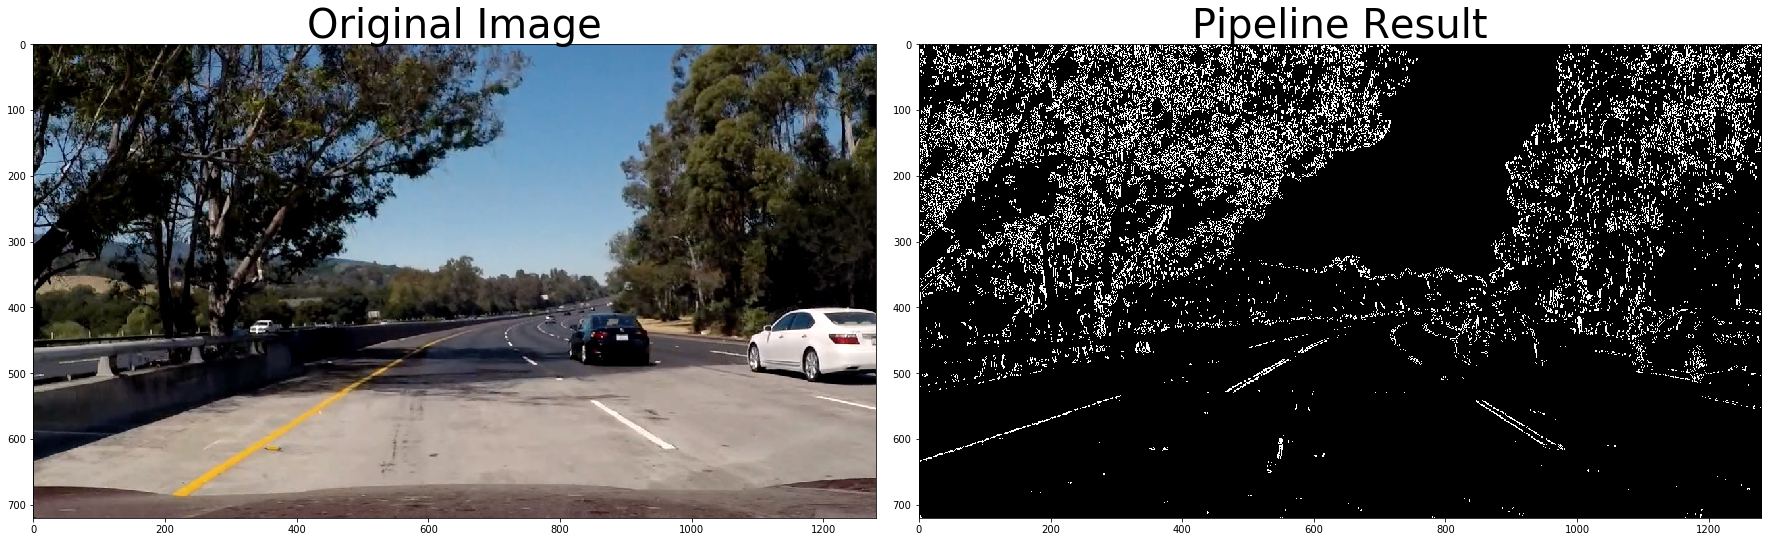

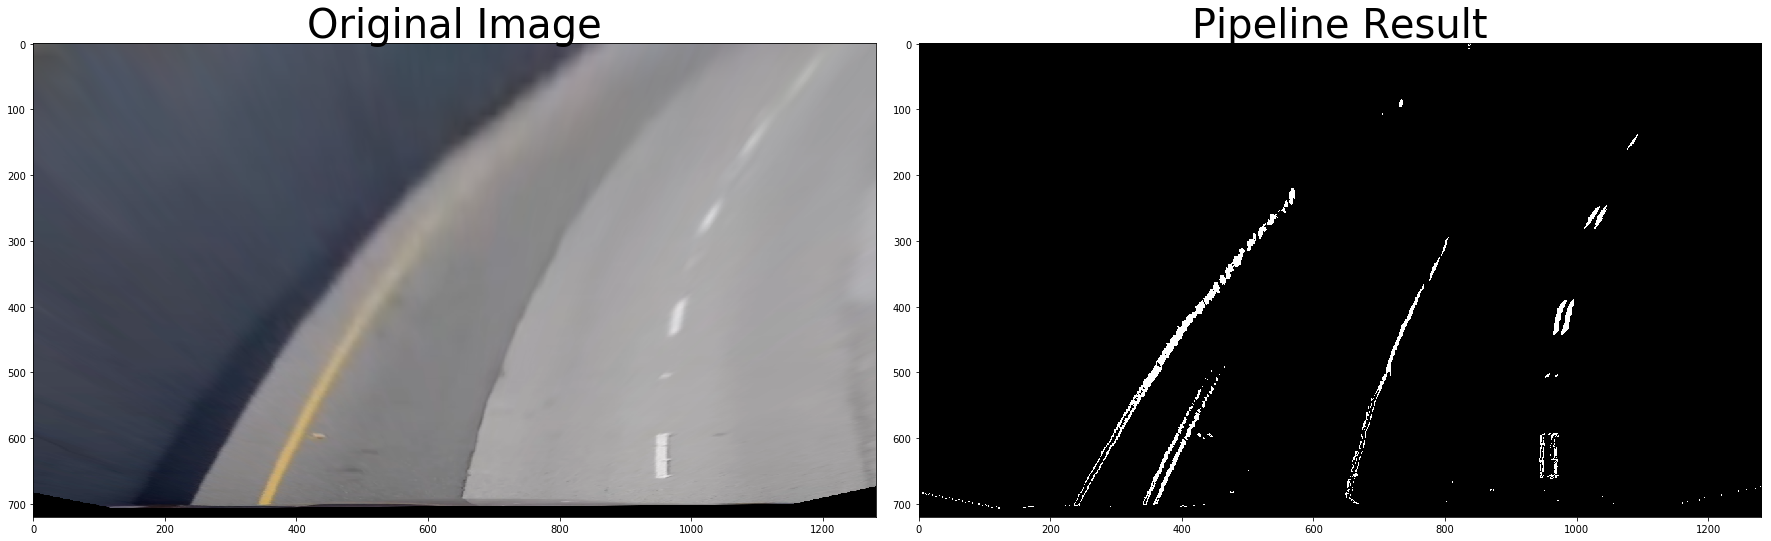

In [177]:
def gradient2(img, s_thresh=(210, 255), sx_thresh=(20, 50)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
#     hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)
    rgb = cv2.cvtColor(cl1, cv2.COLOR_GRAY2RGB)
    hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS).astype(np.float)
    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(l_channel >= s_thresh[0]) | (l_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary [(s_binary == 1) & (sxbinary == 1)] = 1
    return combined_binary

result = gradient2(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

result = gradient2(tr_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(tr_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

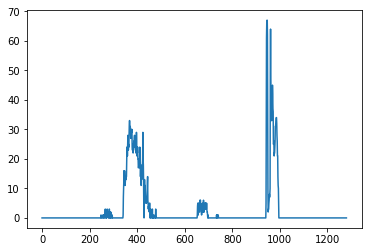

In [165]:
histogram = np.sum(result[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

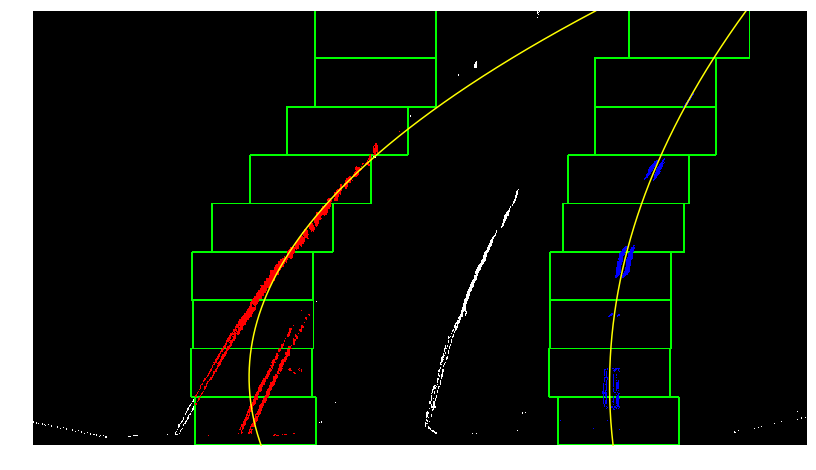

In [178]:
left_fit, right_fit, out_img = lane_lines(result, visualise=True)
left_fitx, right_fitx, ploty = fit_lanes(result, left_fit, right_fit)
plt.figure(figsize=(16,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");

In [167]:
left_fit, right_fit = lane_lines2(result, left_fit, right_fit)
left_fitx, right_fitx, ploty = fit_lanes(result, left_fit, right_fit)

(720, 0)

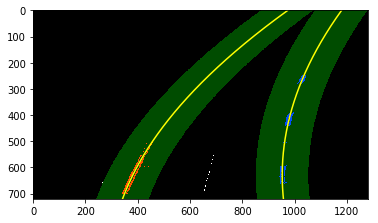

In [168]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((result, result, result))*255

nonzero = result.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

margin = 100
left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                               left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                     left_fit[1] * nonzeroy + left_fit[
                                                                         2] + margin)))

right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))

window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [169]:
#check that parameters lie near mean 
def check(fit, last):
    mean = np.mean(last, axis=0)
    std = np.std(last, axis=0)
    return (np.abs(mean - fit) < 3*std).all()

#
def smooth(fit, last, n):
    if(len(last) < n):
        last.insert(0, fit)
        # return current img lane parameters
        return fit
    elif(check(fit, last)):
        last.pop()
        last.insert(0, fit)
        # if current parameters are good, change queue 
        return fit
    else:
        # if parameters are strange, return smoothed last n imgs lanes
        return np.mean(last, axis=0)

def pipeline(img):
    global first
    global left_fit
    global right_fit
    global last_left
    global last_right
    global n
    obj_points, img_points = read_points()
    undist = cal_undistort(img, obj_points, img_points)
    corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    tr_img, t_m, inv_m = perspective_tr(undist, src, dst, (undist.shape[1], undist.shape[0]))
    binary_warped = gradient2(tr_img)
    if first:
        left_fit, right_fit = lane_lines(binary_warped, visualise=False)
        first = False
    else:
        left_fit, right_fit = lane_lines2(binary_warped, left_fit, right_fit)
    #smooth lanes over last 5 imgs    
#     left_fit = smooth(left_fit, last_left, n)
#     right_fit = smooth(right_fit, last_right, n)
    result = draw(binary_warped, img, inv_m, left_fit, right_fit)
    return result

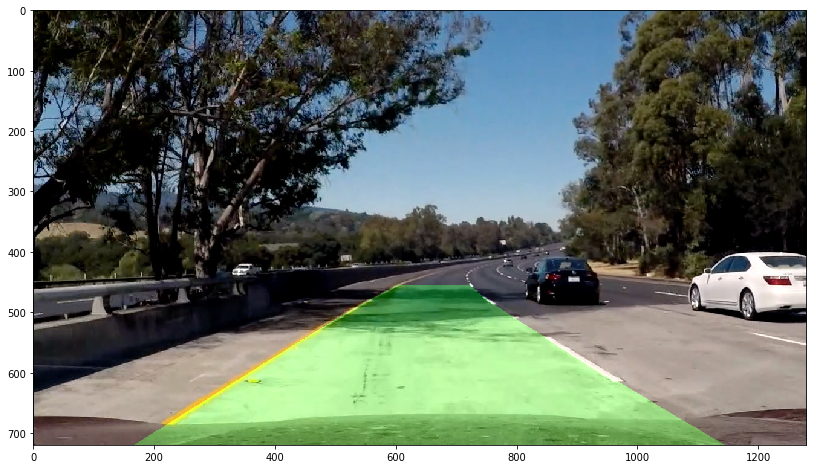

In [170]:
img = cv2.imread('./test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
left_fit = [] 
right_fit = []
last_left= []
last_right = []
n = 5
first = True
result = pipeline(img)
plt.figure(figsize=(16,8))
plt.imshow(result)

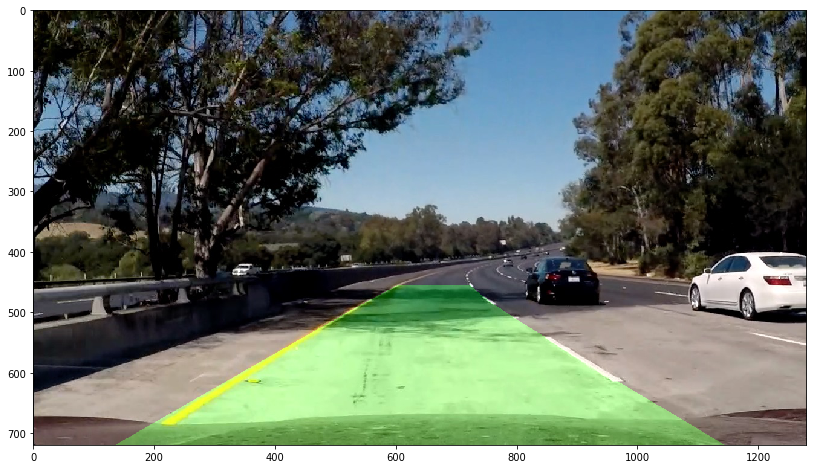

In [171]:
img = cv2.imread('./test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
first = False
# clear queues
last_left= []
last_right = []
result = pipeline(img)
plt.figure(figsize=(16,8))
plt.imshow(result)

In [172]:
video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
left_fit = [] 
right_fit = []
# clear queues
last_left= []
last_right = []
n=5
first = True
clip1_output = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4



100%|█████████▉| 1260/1261 [14:22<00:00,  1.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 14min 22s, sys: 35.4 s, total: 14min 58s
Wall time: 14min 23s


In [173]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [151]:
video_challenge_output = "output_images/project_video_challenge_output.mp4"
clip1 = VideoFileClip("challenge_video.mp4")
left_fit = [] 
right_fit = []
# clear queues
last_left= []
last_right = []
first = True
clip1_output = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_challenge_output.mp4
[MoviePy] Writing video output_images/project_video_challenge_output.mp4



 32%|███▏      | 155/485 [01:39<03:30,  1.56it/s]


 64%|██████▎   | 309/485 [03:18<01:53,  1.56it/s]


 95%|█████████▌| 463/485 [04:58<00:14,  1.56it/s]


100%|█████████▉| 484/485 [05:13<00:00,  1.39it/s]WARNING:py.warnings:/Users/daard/anaconda/envs/carnd-term1/lib/python3.5/site-packages/moviepy/video/io/ffmpeg_reader.py:132: UserWarning: Warning: in file challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)


100%|██████████| 485/485 [05:14<00:00,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_challenge_output.mp4 

CPU times: user 5min 20s, sys: 10.1 s, total: 5min 30s
Wall time: 5min 15s


In [152]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_challenge_output))